# Multiclass Classifiers for Distinction between Evolutionary Scenarios

**Pierrot Van der Aa**

**January 2024**

This script was made based on the sci-kit learn documentation and with the help of the following [MOOC about sci-kit learn](https://lms.fun-mooc.fr/courses/course-v1:inria+41026+session04/info) on the platform FUN.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import plotly.express as px
from itertools import cycle
import csv
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LearningCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder

In [2]:
#Split the data differently than 50/50
def data_split(X, y, nb_split):
    
    #Separate data by class
    class_indices = {}
    for label in np.unique(y):
        class_indices[label] = np.where(y == label)[0]

    #Shuffle each class subset independently
    np.random.seed(42)
    for label, indices in class_indices.items():
        np.random.shuffle(indices)
        class_indices[label] = indices

    #Determine the size of training and test sets
    train_size = nb_split
    test_size = 1 - train_size

    #Allocate balanced samples to training and test sets
    X_train, X_test, y_train, y_test = [], [], [], []
    for label, indices in class_indices.items():
        n_samples = len(indices)
        n_train_samples = int(train_size * n_samples)
        train_indices = indices[:n_train_samples]
        test_indices = indices[n_train_samples:]

        X_train.append(X.iloc[train_indices])
        X_test.append(X.iloc[test_indices])
        y_train.append(y.iloc[train_indices])
        y_test.append(y.iloc[test_indices])

    #Combine samples from all classes
    X_train = np.concatenate(X_train)
    X_test = np.concatenate(X_test)
    y_train = np.concatenate(y_train)
    y_test = np.concatenate(y_test)

    #Shuffle the entire dataset again to mix samples from different classes
    np.random.seed(42)
    shuffle_indices = np.arange(len(y_train))
    np.random.shuffle(shuffle_indices)
    X_train = X_train[shuffle_indices]
    y_train = y_train[shuffle_indices]
    #print(X_test)

    return X_train, X_test, y_train, y_test

In [3]:
#Evaluate the model with a given number of cross-validation iterations (cv) on a given dataset (X) with a target y
def crossval(model, X, y, cv):

    cv_results = cross_validate(
        estimator = model,
        X = X,
        y = y,
        cv = cv,
        return_train_score = True,
        return_estimator = True,
        scoring = 'accuracy'
        )
    
    res = pd.DataFrame(cv_results["test_score"])
    res = res.dropna()
    
    print(f"The average accuracy is {res[0].mean():.3f} ± {res[0].std():.3f}")
    
    return cv_results

In [4]:
#Evaluate the most occurring string in a list of strings
def winner_takes_all(strings_list):
    
    # Count occurrences of each string
    counts = Counter(strings_list)
    
    # Find the string with the maximum count
    winner = max(counts, key=counts.get)
    
    return winner

In [5]:
#Predict the target value for each model from the cross-validation and compare them to the real target
def report(res_estim, X, y_true, labels):

    predi_list = []
    y_pred = []

    #Predict the label for each x in the test set X
    for estim in res_estim['estimator']:

        predi_list.append(estim.predict(X))

    #Loop through all the predictions in a given iteration of the cross-validation
    for elem in predi_list[0]:

        temp_all_cv = []
        winner = ''

        #Loop through the n lists of the prediction where n is the number of cross-validation folds of the outer_cv
        for l in predi_list:

            temp_all_cv.append(elem)

        y_pred.append(winner_takes_all(temp_all_cv))
    
    #Display a classification report with different metrics and a confusion matrix
    print(classification_report(y_true, y_pred, target_names=labels))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=labels)
    
    return y_pred

In [6]:
def plot_multiclass_roc(X_train, y_train, X_test, y_test, classifier):

    # Binarize the output
    y_test = label_binarize(y_test, classes=np.unique(y_test))

    # Learn to predict each class against the other
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    n_classes = y_test.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and ROC area
    fpr["macro"], tpr["macro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curves
    plt.figure()
    lw = 2
    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (AUC = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='deeppink', linestyle=':', linewidth=4)

    colors = ['aqua', 'darkorange', 'cornflowerblue', 'lime'][:n_classes]
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (AUC = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [7]:
#Load the data
full_data = pd.read_csv("/home/pierrot/pCloudDrive/Mabisbis/Thesis/Multiclass/full_dataset.csv", header = 0)
full_data.head()

,V1,Hs_Pop1,Hs_Pop2,Hs_Pop3,Hs_Pop4,Ht,Gst,Htmax,Gstmax,Gprimest,...,TajimaD_pop3,TajimaD_pop4,filename,dxy_Pop1_2,dxy_Pop1_3,dxy_Pop1_4,dxy_Pop2_3,dxy_Pop2_4,dxy_Pop3_4,hypothesis
0,Hypothesis00_mut8_pop4_1_1.arp.vcf,0.191,0.199,0.198,0.198,0.197,0.002,0.799,0.762,0.002,...,3.745958,3.381819,Hypothesis00_mut8_pop4_1_1.arp.vcf.gz,0.053473,0.053826,0.053767,0.042947,0.042830,0.043295,hyp00
1,Hypothesis00_mut8_pop4_10_1.arp.vcf,0.175,0.175,0.176,0.177,0.178,0.009,0.794,0.783,0.012,...,3.504708,3.200535,Hypothesis00_mut8_pop4_10_1.arp.vcf.gz,0.007122,0.006998,0.006869,0.005777,0.005666,0.005540,hyp00
2,Hypothesis00_mut8_pop4_100_1.arp.vcf,0.192,0.199,0.197,0.197,0.197,0.003,0.799,0.762,0.005,...,3.721749,3.337637,Hypothesis00_mut8_pop4_100_1.arp.vcf.gz,0.046937,0.046630,0.046116,0.037459,0.036878,0.036718,hyp00
3,Hypothesis00_mut8_pop4_1000_1.arp.vcf,0.193,0.201,0.200,0.200,0.199,0.002,0.799,0.759,0.002,...,3.747718,3.380211,Hypothesis00_mut8_pop4_1000_1.arp.vcf.gz,0.079706,0.078592,0.079174,0.064498,0.064955,0.063910,hyp00
4,Hypothesis00_mut8_pop4_10000_1.arp.vcf,0.192,0.200,0.199,0.199,0.198,0.002,0.799,0.761,0.002,...,3.747328,3.383067,Hypothesis00_mut8_pop4_10000_1.arp.vcf.gz,0.077640,0.078228,0.077330,0.064466,0.063833,0.064308,hyp00


In [8]:
#Load the real life data point
sample_life = pd.read_csv("/home/pierrot/pCloudDrive/Mabisbis/Thesis/Multiclass/Summary_statistics_sample_life_bis.csv", header = 0)
sample_life.head()

,Hs_Pop1,Hs_Pop2,Hs_Pop3,Hs_Pop4,Ht,Gst,Htmax,Gstmax,Gprimest,a,...,TajimaD_pop2,TajimaD_pop3,TajimaD_pop4,filename,dxy_Pop1_2,dxy_Pop1_3,dxy_Pop1_4,dxy_Pop2_3,dxy_Pop2_4,dxy_Pop3_4
0,0.15,0.158,0.156,0.145,0.159,0.033,0.775,0.814,0.042,3.355,...,-0.185701,0.301646,0.442425,sample_life_sorted.vcf.gz,0.006037,0.00591,0.005889,0.004164,0.004141,0.002412


In [9]:
#Split the data into features and target variable
data, target = full_data.drop(columns=["V1","D_mean","filename","hypothesis"]), full_data["hypothesis"]
target_names = list(target.unique())
#target = LabelEncoder().fit_transform(target.astype('str'))
feature_names = list(data.columns)
sample_life = sample_life.drop(columns=["D_mean","filename"])
print(data.shape)
print(target.shape)
print(target_names)
print(feature_names)

(39445, 84)
(39445,)
['hyp00', 'hyp01', 'hyp02', 'hyp03']
['Hs_Pop1', 'Hs_Pop2', 'Hs_Pop3', 'Hs_Pop4', 'Ht', 'Gst', 'Htmax', 'Gstmax', 'Gprimest', 'a', 'b', 'Dest_Chao', 'Hs', 'Ht.1', 'Gst_est', 'Gprime_st', 'D_het', 'Phi_st', 'Fst', 'Fis', 'Ho', 'Hs.1', 'Ht.2', 'Dst', 'Htp', 'Dstp', 'Fst.1', 'Fstp', 'Fis.1', 'Dest', 'Mean_kinship', 'dist_Dch_Pop1_2', 'dist_Dch_Pop1_3', 'dist_Dch_Pop1_4', 'dist_Dch_Pop2_3', 'dist_Dch_Pop2_4', 'dist_Dch_Pop3_4', 'dist_Da_Pop1_2', 'dist_Da_Pop1_3', 'dist_Da_Pop1_4', 'dist_Da_Pop2_3', 'dist_Da_Pop2_4', 'dist_Da_Pop3_4', 'dist_Ds_Pop1_2', 'dist_Ds_Pop1_3', 'dist_Ds_Pop1_4', 'dist_Ds_Pop2_3', 'dist_Ds_Pop2_4', 'dist_Ds_Pop3_4', 'beta_Pop1_2', 'beta_Pop1_3', 'beta_Pop1_4', 'beta_Pop2_3', 'beta_Pop2_4', 'beta_Pop3_4', 'neifst_Pop1_2', 'neifst_Pop1_3', 'neifst_Pop1_4', 'neifst_Pop2_3', 'neifst_Pop2_4', 'neifst_Pop3_4', 'WCfst_Pop1_2', 'WCfst_Pop1_3', 'WCfst_Pop1_4', 'WCfst_Pop2_3', 'WCfst_Pop2_4', 'WCfst_Pop3_4', 'pi', 'TajimaD', 'theta', 'pi_pop1', 'pi_pop2',

In [10]:
#Split the data into training and test set while preserving the class balance but with the constraint of a 50/50 split
stratified_kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

for train_index, test_index in stratified_kfold.split(data, target):
    
    X_train, X_test = data.iloc[train_index], data.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

In [11]:
X_train, X_test, y_train, y_test = data_split(data, target, 0.5)

In [12]:
#Set the parameters for the cross-validation
#inner cross-validation: evaluation of the hyperparameters
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
#outer cross-validation: evaluation of the model
outer_cv = ShuffleSplit(n_splits = 10, train_size = 0.8, random_state = 42)

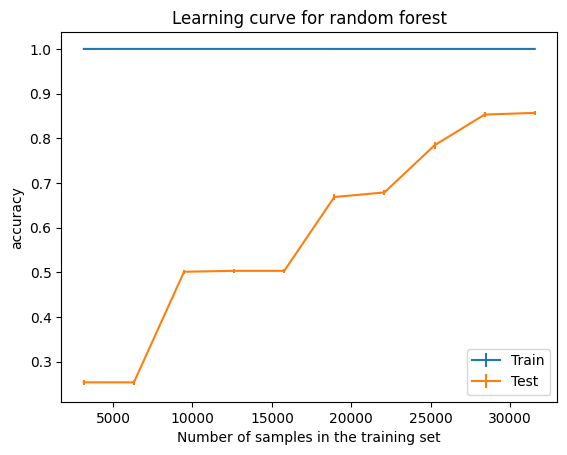

In [13]:
#Learning curve, which proportion of the dataset is required for an effective training of the random forest classifier

#Define the dataset fractions to test
percent_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

display = LearningCurveDisplay.from_estimator(
    RandomForestClassifier(random_state=42),
    data,
    target,
    train_sizes=percent_list,
    cv=inner_cv,
    score_type="both",  # both train and test errors
    scoring="accuracy",
    negate_score=False,  # to use when metric starts with "neg_"
    score_name="accuracy",
    std_display_style="errorbar",
    n_jobs=2,
)
_ = display.ax_.set(xscale="linear", title="Learning curve for random forest")

The average accuracy is 0.252 ± 0.004
              precision    recall  f1-score   support

       hyp00       0.26      0.26      0.26      5000
       hyp01       0.25      0.25      0.25      5000
       hyp02       0.24      0.24      0.24      4723
       hyp03       0.26      0.26      0.26      5000

    accuracy                           0.25     19723
   macro avg       0.25      0.25      0.25     19723
weighted avg       0.25      0.25      0.25     19723



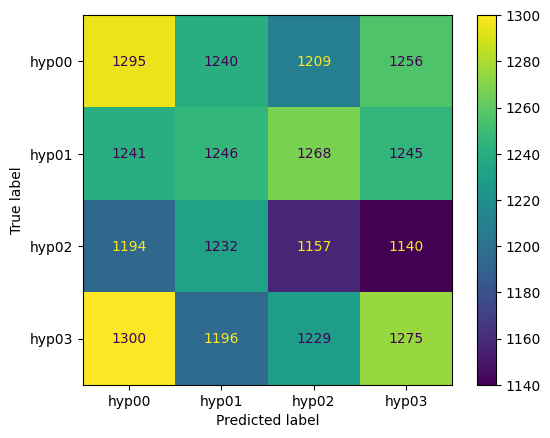

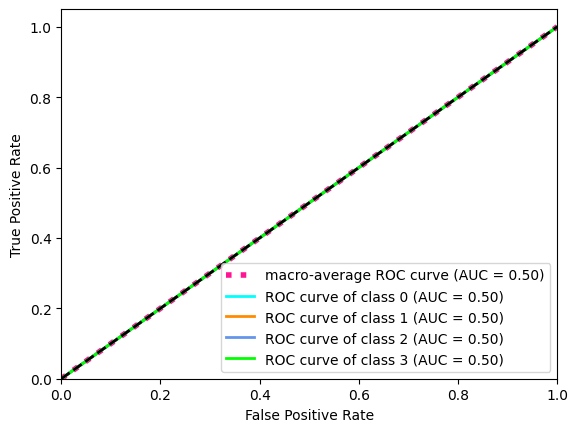

/home/pierrot/.local/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


array([[0.25, 0.25, 0.25, 0.25]])

In [14]:
#Create a pipeline for a dummy classifier
dummy = make_pipeline(
    StandardScaler(), DummyClassifier(strategy = "uniform", random_state = 42)
)

#Evaluate the model with a ten-fold cross-validation
res_dummy = crossval(dummy, X_train, y_train, outer_cv)
y_dummy = report(res_dummy, X_test, y_test, target_names)
plot_multiclass_roc(X_train, y_train, X_test, y_test, dummy)
dummy.predict_proba(sample_life)

In [15]:
#Create a pipeline for a simple logistic regression model
logistic = make_pipeline(
    StandardScaler(), LogisticRegression(random_state = 42, n_jobs = 4, max_iter = 10000)
)

#Evaluate the model with a ten-fold cross-validation
res_logistic = crossval(logistic, X_train, y_train, outer_cv)

The average accuracy is 0.795 ± 0.005


In [16]:
#Find the hyperparameters that need to be tuned
logistic.get_params()
"""
C: strength of the regularization. Positive float. 0.01 to 10000 in logistic dist?
class_weight: weights associated to each classes. Not applicable in our case because we have balanced classes.
dual: Not applicable because we use 'lbfgs' and not 'liblinear'
fit_intercept: Leave the default to True else we force the model to go through (0,0)
intercept_scaling: Not applicable because we use 'lbfgs' and not 'liblinear'
l1_ratio: left to default None because the model 'lbfgs' only handles l2 penalty.
max_iter: number of iterations for convergence: default is 100. 100 to 10000 in logistic dist?
multi_class: can be left on 'auto'
n_jobs: number of cores for parallelisation. Can be set to -1 to use all cores or 4 (one for each class)
penalty: default is l2 and can be left on default
random_state: 42: allows for reproducibility of analyses
solver: algorithm chosen: 'lbfgs'
tol: tolerance for stopping, default is 0.0001. 0.000001 and 0.1 logistic dist?
verbose: leave the default 0 for non-verbose
warm_start: False: set to True if we reuse the previous fit as starting point
"""

"\nC: strength of the regularization. Positive float. 0.01 to 10000 in logistic dist?\nclass_weight: weights associated to each classes. Not applicable in our case because we have balanced classes.\ndual: Not applicable because we use 'lbfgs' and not 'liblinear'\nfit_intercept: Leave the default to True else we force the model to go through (0,0)\nintercept_scaling: Not applicable because we use 'lbfgs' and not 'liblinear'\nl1_ratio: left to default None because the model 'lbfgs' only handles l2 penalty.\nmax_iter: number of iterations for convergence: default is 100. 100 to 10000 in logistic dist?\nmulti_class: can be left on 'auto'\nn_jobs: number of cores for parallelisation. Can be set to -1 to use all cores or 4 (one for each class)\npenalty: default is l2 and can be left on default\nrandom_state: 42: allows for reproducibility of analyses\nsolver: algorithm chosen: 'lbfgs'\ntol: tolerance for stopping, default is 0.0001. 0.000001 and 0.1 logistic dist?\nverbose: leave the default

In [17]:
#From the analysis above we want to analyse the following hyperparameters:
param_distributions_logistic = {
    'logisticregression__C': np.logspace(-2, 4, num=14).astype(np.float32)
}

logistic_random_search = GridSearchCV(
    logistic,
    param_grid=param_distributions_logistic,
    cv=inner_cv,
    n_jobs=2,
    verbose=1,
)

logistic_random_search.fit(X_train, y_train)
logistic_random_search.best_params_

Fitting 5 folds for each of 14 candidates, totalling 70 fits


/home/pierrot/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/pierrot/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

{'logisticregression__C': 10000.0}

In [18]:
#From the analysis above we want to finetune around the best hyperparameter:
best_C = logistic_random_search.best_params_['logisticregression__C']
#best_C = 10000.0
param_distributions_logistic_bis = {
    'logisticregression__C': np.linspace(best_C-20, best_C+20, num=10).astype(np.float32)
}

logistic_random_search_bis = GridSearchCV(
    logistic,
    param_grid=param_distributions_logistic_bis,
    cv=inner_cv,
    n_jobs=2,
    verbose=1,
)

logistic_random_search_bis.fit(X_train, y_train)
logistic_random_search_bis.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/pierrot/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/pierrot/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

{'logisticregression__C': 10006.667}

/home/pierrot/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/pierrot/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

The average accuracy is 0.824 ± 0.004
              precision    recall  f1-score   support

       hyp00       0.77      0.59      0.67      5000
       hyp01       0.96      0.99      0.97      5000
       hyp02       0.72      0.82      0.77      4723
       hyp03       0.80      0.86      0.83      5000

    accuracy                           0.81     19723
   macro avg       0.81      0.81      0.81     19723
weighted avg       0.81      0.81      0.81     19723



/home/pierrot/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


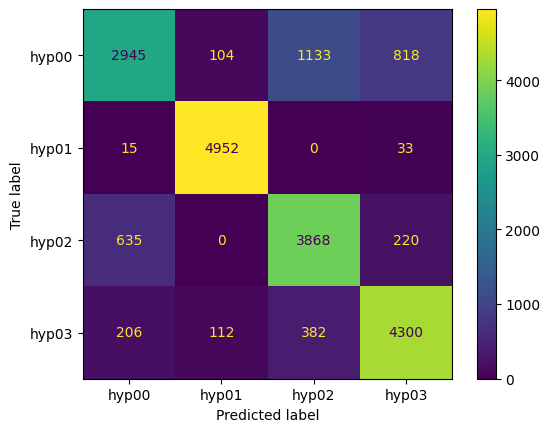

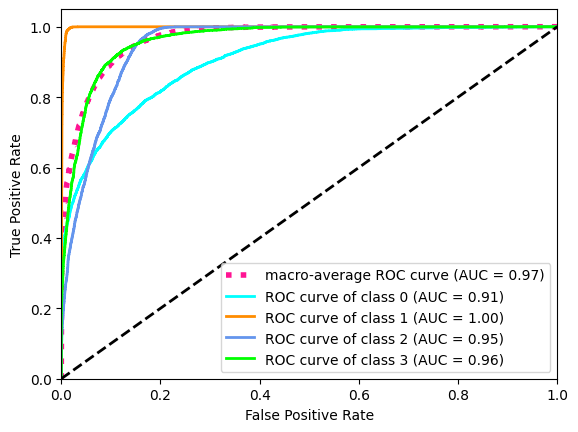

/home/pierrot/.local/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


array([[0.00000000e+000, 0.00000000e+000, 1.00000000e+000,
        3.26148831e-146]])

In [19]:
#We can now rerun the analysis with the best hyperparameters and plot a report of the model performance on the test set
best_C_bis = logistic_random_search_bis.best_params_['logisticregression__C']
#best_C_bis = 9988.889
logistic = make_pipeline(
    StandardScaler(), LogisticRegression(random_state = 42, n_jobs = 4, max_iter = 10000, C = best_C_bis)
)
res_logistic = crossval(logistic, X_train, y_train, outer_cv)
y_logistic = report(res_logistic, X_test, y_test, target_names)
plot_multiclass_roc(X_train, y_train, X_test, y_test, logistic)
logistic.predict_proba(sample_life)

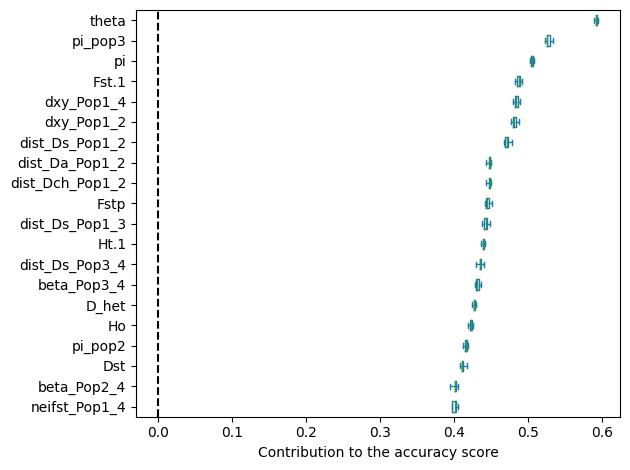

In [20]:
# Permutation Importance to retrieve the importance of each feature
result_logistic = permutation_importance(logistic, X_train, y_train, n_repeats=10,
                                 random_state=42)

sorted_importances_idx = result_logistic.importances_mean.argsort()
importances = pd.DataFrame(
    result_logistic.importances[sorted_importances_idx].T,
    columns=data.columns[sorted_importances_idx],
)

# Select the 20 most important features
top_importances = importances.iloc[:, -20:]

# Box plot of the 20 most relevant features
ax = top_importances.plot.box(vert=False, whis=10)
#ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Contribution to the accuracy score")
ax.figure.tight_layout()

In [21]:
#NOT WORKING for some unknown reason
"""
#Plot the search for best hyperparameters
logistic_results = pd.DataFrame(logistic_random_search.cv_results_)

column_name_mapping = {
    "param_logisticregression__C": "C",
    "mean_test_score": "mean test score",
}

logistic_results = logistic_results.rename(columns=column_name_mapping)
logistic_results = logistic_results[column_name_mapping.values()].sort_values(
    "mean test score", ascending=False
)

fig = px.parallel_coordinates(
    logistic_results,
    color="mean test score",
    dimensions=["C", "mean test score"],
    color_continuous_scale=px.colors.diverging.Tealrose,
)
fig.show() #I don't know why this interactive plot doesn't work ..."""

'\n#Plot the search for best hyperparameters\nlogistic_results = pd.DataFrame(logistic_random_search.cv_results_)\n\ncolumn_name_mapping = {\n    "param_logisticregression__C": "C",\n    "mean_test_score": "mean test score",\n}\n\nlogistic_results = logistic_results.rename(columns=column_name_mapping)\nlogistic_results = logistic_results[column_name_mapping.values()].sort_values(\n    "mean test score", ascending=False\n)\n\nfig = px.parallel_coordinates(\n    logistic_results,\n    color="mean test score",\n    dimensions=["C", "mean test score"],\n    color_continuous_scale=px.colors.diverging.Tealrose,\n)\nfig.show() #I don\'t know why this interactive plot doesn\'t work ...'

In [22]:
#Create a pipeline for a simple decision tree model
tree = make_pipeline(
    StandardScaler(), DecisionTreeClassifier(random_state = 42)
)

#Evaluate the model with a ten-fold cross-validation
res_tree = crossval(tree, X_train, y_train, outer_cv)

The average accuracy is 0.784 ± 0.004


In [23]:
#We want to analyse the following hyperparameters:
param_distributions_tree = {
    'decisiontreeclassifier__max_depth': np.logspace(0, 2, num=20).astype(np.int32)
}

tree_random_search = GridSearchCV(
    tree,
    param_grid=param_distributions_tree,
    cv=inner_cv,
    n_jobs=2,
    verbose=1,
)

tree_random_search.fit(X_train, y_train)
tree_random_search.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'decisiontreeclassifier__max_depth': 8}

In [24]:
#We want to analyse further the following hyperparameter:
best_depth_tree = tree_random_search.best_params_['decisiontreeclassifier__max_depth']
#best_depth_tree = 8
param_distributions_tree_bis = {
    'decisiontreeclassifier__max_depth': np.linspace(best_depth_tree-5, best_depth_tree+5, num=10).astype(np.int32)
}

tree_random_search_bis = GridSearchCV(
    tree,
    param_grid=param_distributions_tree_bis,
    cv=inner_cv,
    n_jobs=2,
    verbose=1,
)

tree_random_search_bis.fit(X_train, y_train)
tree_random_search_bis.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'decisiontreeclassifier__max_depth': 9}

The average accuracy is 0.832 ± 0.007
              precision    recall  f1-score   support

       hyp00       0.75      0.67      0.71      5000
       hyp01       0.97      0.98      0.98      5000
       hyp02       0.78      0.80      0.79      4723
       hyp03       0.80      0.85      0.83      5000

    accuracy                           0.83     19723
   macro avg       0.83      0.83      0.83     19723
weighted avg       0.83      0.83      0.83     19723



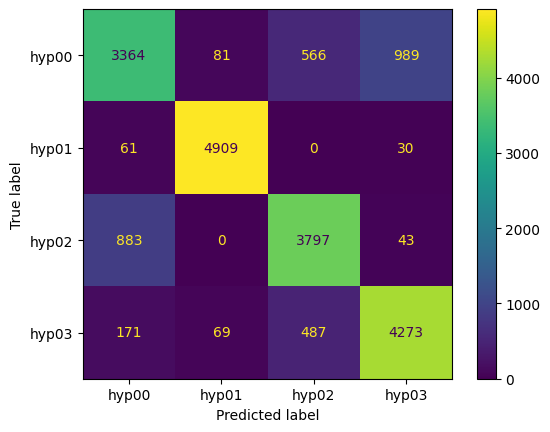

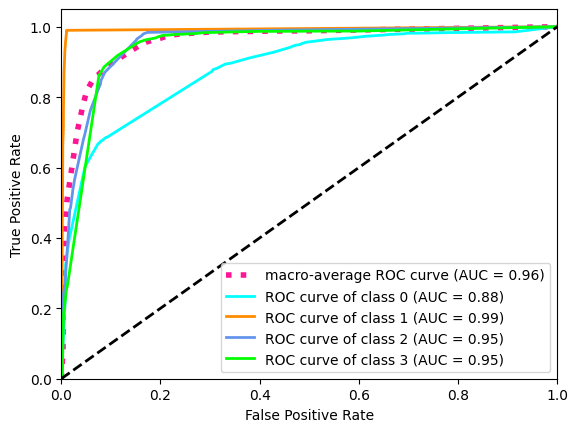

/home/pierrot/.local/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


array([[0., 1., 0., 0.]])

In [25]:
#We can now rerun the analysis with the best hyperparameters and plot a report of the model performance on the test set
best_depth_tree_bis = tree_random_search_bis.best_params_['decisiontreeclassifier__max_depth']
#best_depth_tree_bis = 10
tree = make_pipeline(
    StandardScaler(), DecisionTreeClassifier(random_state = 42, max_depth = best_depth_tree_bis)
)
res_tree = crossval(tree, X_train, y_train, outer_cv)
y_tree = report(res_tree, X_test, y_test, target_names)
plot_multiclass_roc(X_train, y_train, X_test, y_test, tree)
tree.predict_proba(sample_life)

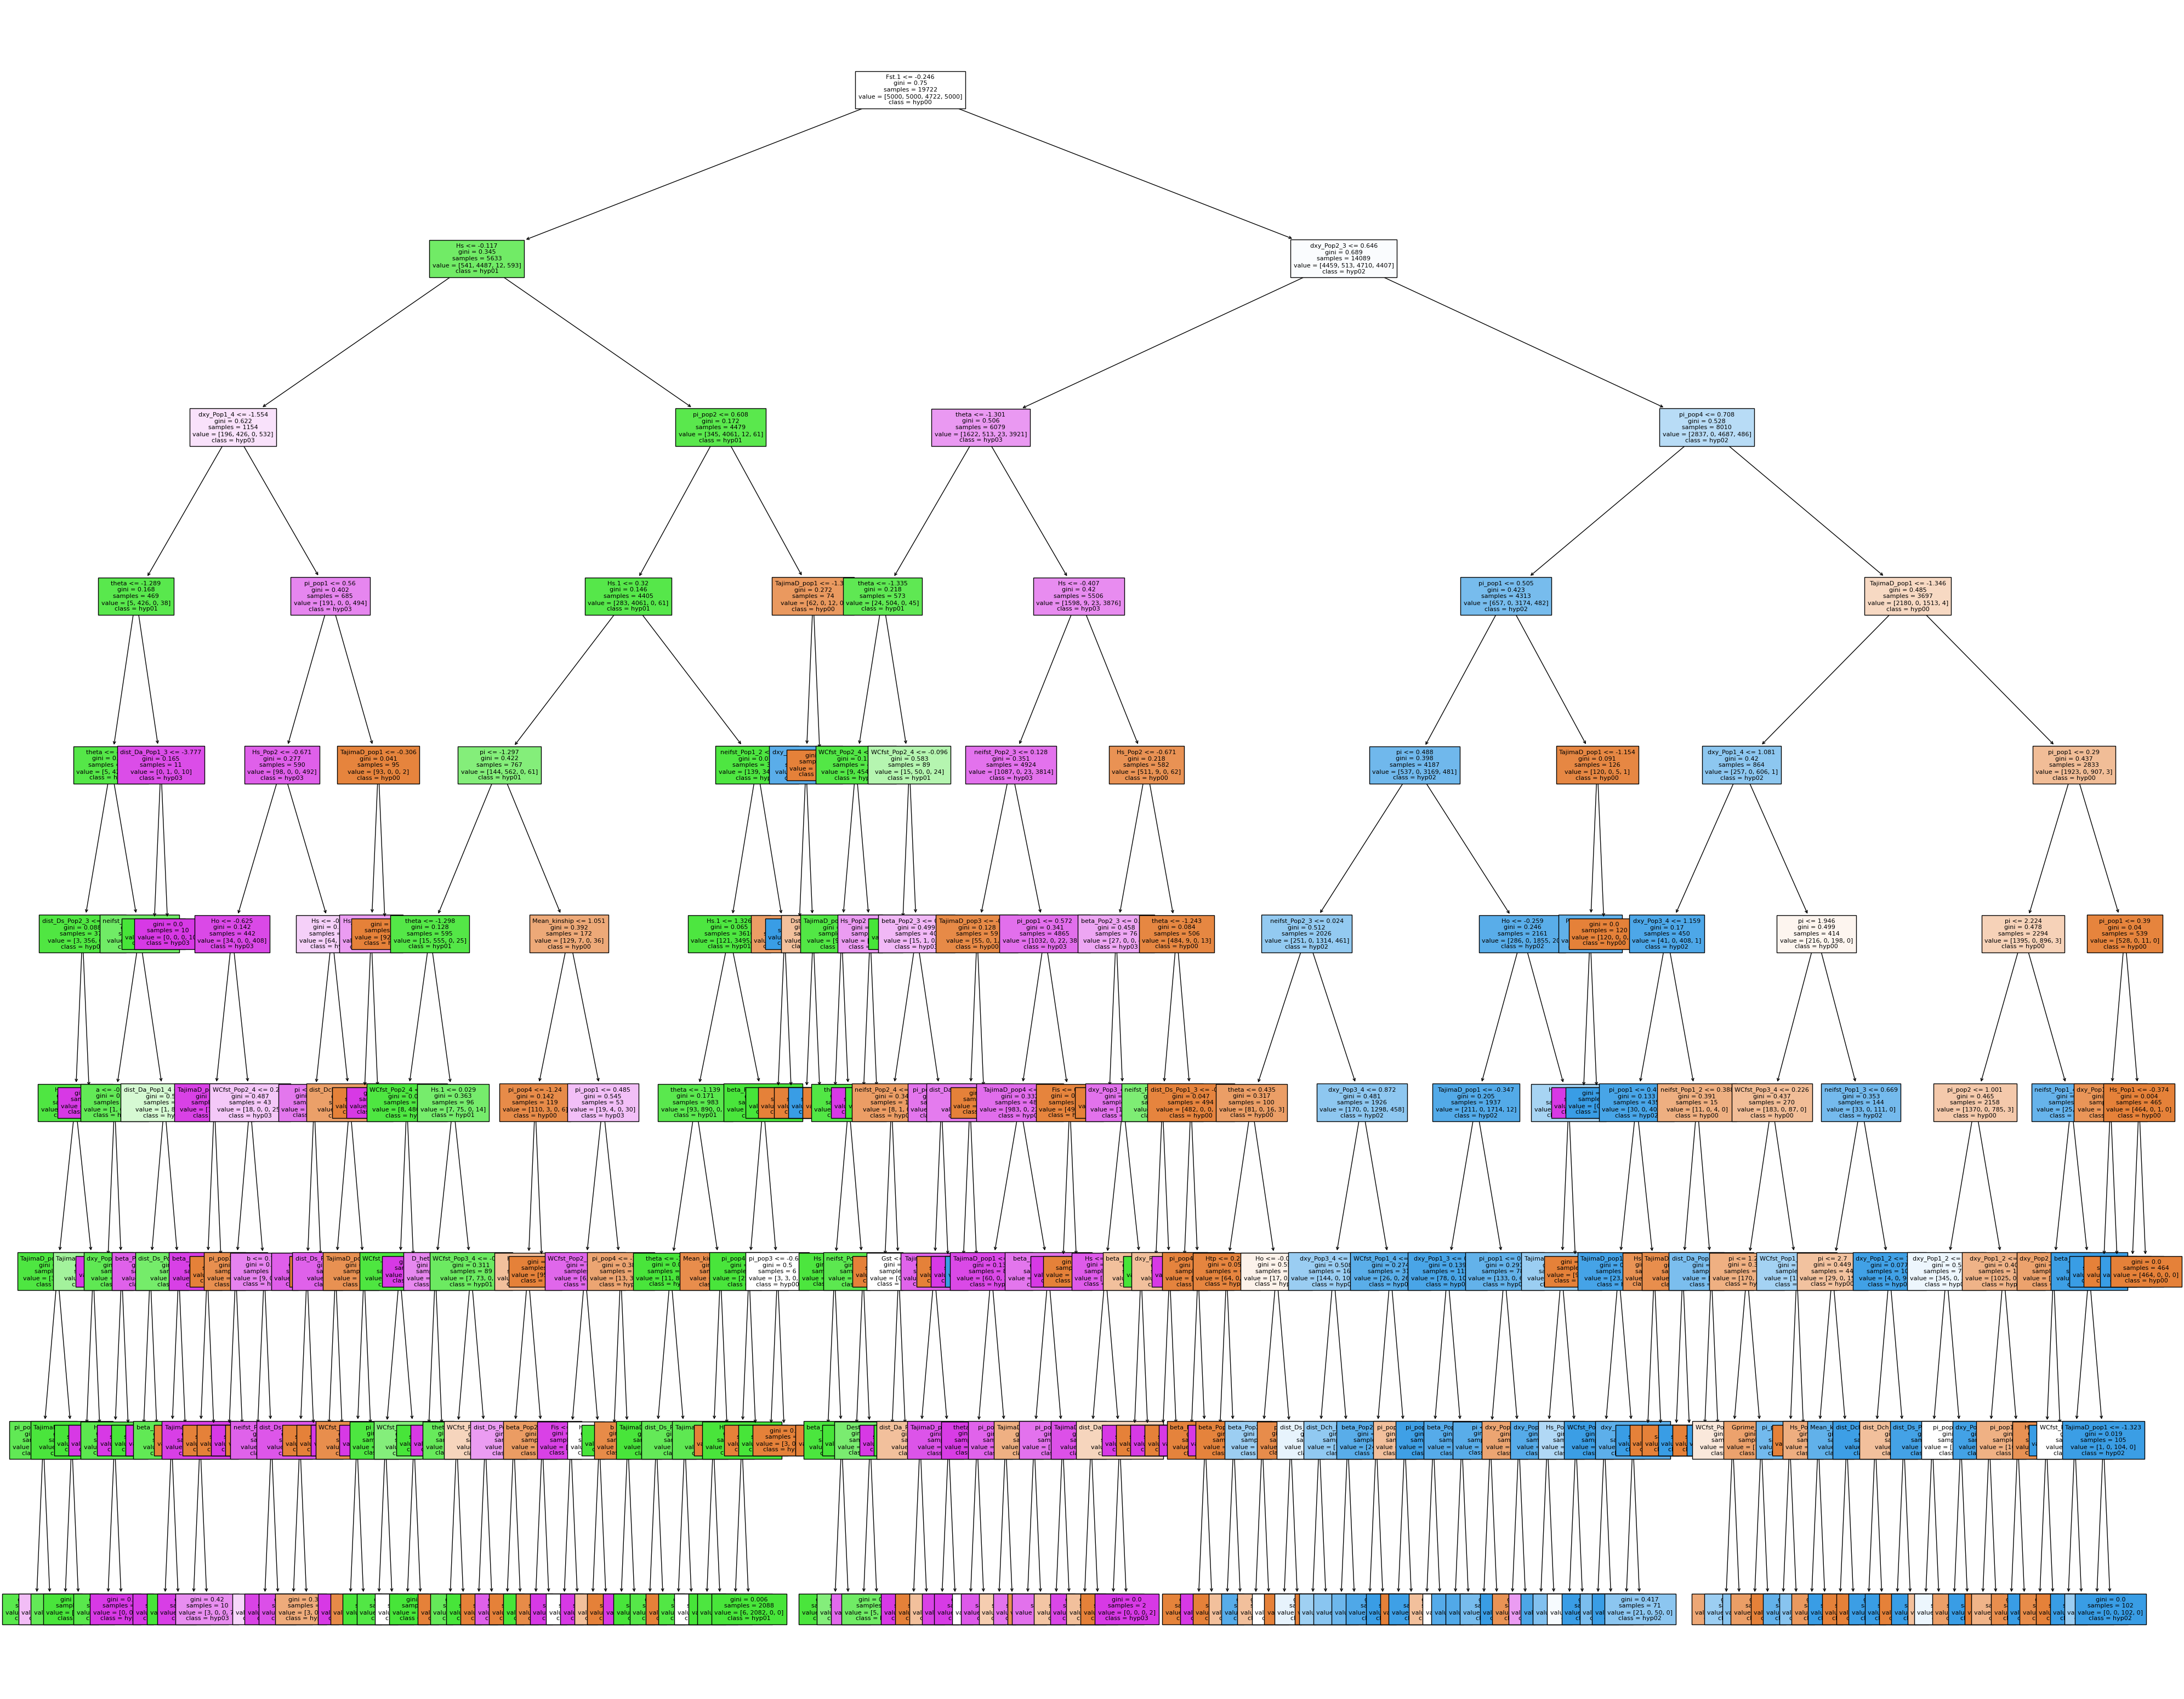

In [26]:
#Plot the decision tree
plt.figure(figsize=(50, 40))
tree.fit(X_train, y_train)
plot_tree(tree.named_steps['decisiontreeclassifier'], filled=True, feature_names=feature_names, class_names=target_names, fontsize=8)
plt.show()

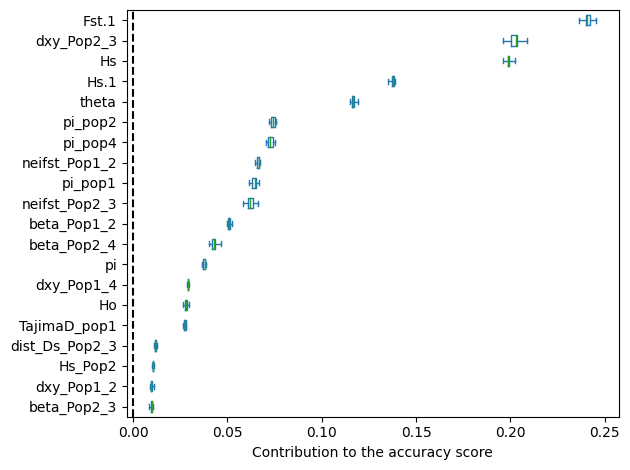

In [27]:
# Permutation Importance to retrieve the importance of each feature
result_tree = permutation_importance(tree, X_train, y_train, n_repeats=10,
                                 random_state=42)

sorted_importances_idx = result_tree.importances_mean.argsort()
importances = pd.DataFrame(
    result_tree.importances[sorted_importances_idx].T,
    columns=data.columns[sorted_importances_idx],
)

# Select the 20 most important features
top_importances = importances.iloc[:, -20:]

# Box plot of the 20 most relevant features
ax = top_importances.plot.box(vert=False, whis=10)
#ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Contribution to the accuracy score")
ax.figure.tight_layout()

In [40]:
#Create a pipeline for a random forest model
forest = make_pipeline(
    StandardScaler(), RandomForestClassifier(random_state=42)
)

#Evaluate the model with a ten-fold cross-validation
crossval(forest, X_train, y_train, outer_cv)

The average accuracy is 0.856 ± 0.003


{'fit_time': array([9.93036389, 9.73805761, 9.85615063, 9.86574936, 9.85595632,
        9.95215678, 9.75040531, 9.83063674, 9.87069011, 9.82859826]),
 'score_time': array([0.05167484, 0.05361557, 0.05411315, 0.05388594, 0.05367208,
        0.05439138, 0.05363369, 0.05361319, 0.0535872 , 0.05299711]),
 'estimator': [Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('randomforestclassifier',
                   RandomForestClassifier(random_state=42))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('randomforestclassifier',
                   RandomForestClassifier(random_state=42))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('randomforestclassifier',
                   RandomForestClassifier(random_state=42))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('randomforestclassifier',
                   RandomForestClassifier(random_state=42))]),
  Pipeline(steps=[('standards

In [41]:
#We want to analyse the following hyperparameters:
param_distributions_forest = {
    'randomforestclassifier__max_depth': np.logspace(0, 2, num=10).astype(np.int32),
    'randomforestclassifier__n_estimators': np.logspace(0, 3, num=10).astype(np.int32)
}

forest_random_search = GridSearchCV(
    forest,
    param_grid=param_distributions_forest,
    cv=inner_cv,
    n_jobs=2,
    verbose=1,
)

forest_random_search.fit(X_train, y_train)
forest_random_search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'randomforestclassifier__max_depth': 59,
 'randomforestclassifier__n_estimators': 215}

In [42]:
#We want to further analyse the following hyperparameters:
best_depth_forest = forest_random_search.best_params_['randomforestclassifier__max_depth']
best_n_forest = forest_random_search.best_params_['randomforestclassifier__n_estimators']
#best_depth_forest = 21
#best_n_forest = 1000
param_distributions_forest_bis = {
    'randomforestclassifier__max_depth': np.linspace(best_depth_forest-5, best_depth_forest+5, num=10).astype(np.int32),
    'randomforestclassifier__n_estimators': np.linspace(best_n_forest-10, best_n_forest+10, num=5).astype(np.int32)
}

forest_random_search_bis = GridSearchCV(
    forest,
    param_grid=param_distributions_forest_bis,
    cv=inner_cv,
    n_jobs=2,
    verbose=1,
)

forest_random_search_bis.fit(X_train, y_train)
forest_random_search_bis.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'randomforestclassifier__max_depth': 54,
 'randomforestclassifier__n_estimators': 210}

The average accuracy is 0.855 ± 0.004
              precision    recall  f1-score   support

       hyp00       0.83      0.68      0.75      5000
       hyp01       0.97      1.00      0.98      5000
       hyp02       0.80      0.85      0.82      4723
       hyp03       0.82      0.89      0.85      5000

    accuracy                           0.85     19723
   macro avg       0.85      0.85      0.85     19723
weighted avg       0.85      0.85      0.85     19723



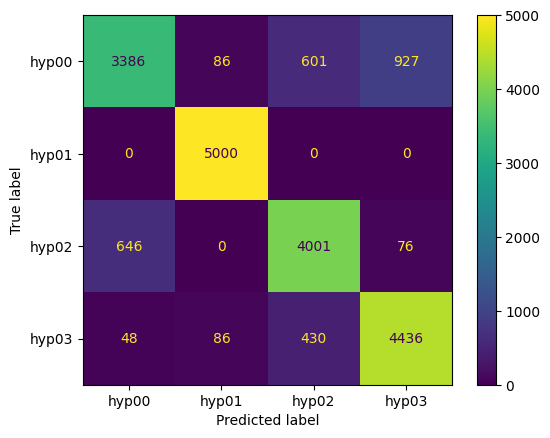

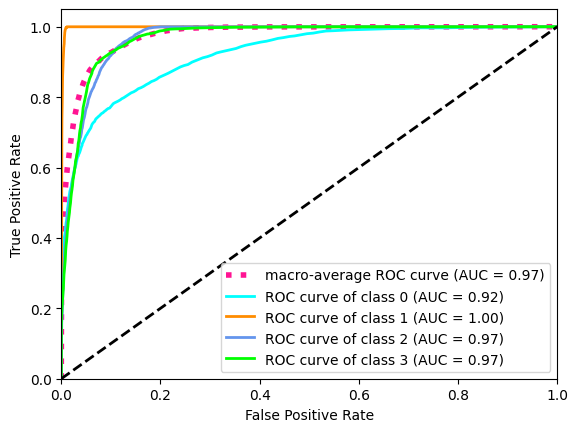

/home/pierrot/.local/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


array([[0.3047619 , 0.32380952, 0.02380952, 0.34761905]])

In [43]:
#We can now rerun the analysis with the best hyperparameters and plot a report of the model performance on the test set
best_depth_forest_bis = forest_random_search_bis.best_params_['randomforestclassifier__max_depth']
best_n_forest_bis = forest_random_search_bis.best_params_['randomforestclassifier__n_estimators']
#best_depth_forest_bis = 23
#best_n_forest_bis = 1005
forest = make_pipeline(
    StandardScaler(), RandomForestClassifier(random_state = 42, 
                                             max_depth = best_depth_forest_bis,
                                             n_estimators = best_n_forest_bis)
)
res_forest = crossval(forest, X_train, y_train, outer_cv)
y_forest = report(res_forest, X_test, y_test, target_names)
plot_multiclass_roc(X_train, y_train, X_test, y_test, forest)
forest.predict_proba(sample_life)

In [44]:
#We now, want to retrieve the most important features
forest = RandomForestClassifier(random_state=42, 
                                             max_depth = best_depth_forest_bis,
                                             n_estimators = best_n_forest_bis)
forest.fit(X_train, y_train)

# Retrieve feature importances
feature_importances = forest.feature_importances_

In [45]:
feature_importance_named = {}
i = 0

for feature in feature_names:
    feature_importance_named[feature] = feature_importances[i]
    #print(f"{feature}: Importance = {feature_importances[i]}")
    i += 1

features_ranked = sorted(feature_importance_named.items(), key=lambda x:x[1], reverse=True)
for elem in features_ranked:
    print(elem)

with open('/home/pierrot/pCloudDrive/Mabisbis/Thesis/Multiclass/feature_importance.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['name_of_the_feature','importance'])
    for row in features_ranked:
        csv_out.writerow(row)

('dxy_Pop1_3', 0.04113405720386898)
('dxy_Pop1_2', 0.03905741571158587)
('Hs', 0.03772735562097851)
('pi', 0.03657801147542636)
('dxy_Pop3_4', 0.03461074756921752)
('Gst_est', 0.032239819821264615)
('pi_pop3', 0.031269926384636416)
('dxy_Pop2_3', 0.031146482944545934)
('pi_pop4', 0.031128304516137295)
('theta', 0.030811779253350737)
('pi_pop2', 0.030148740208582263)
('dxy_Pop2_4', 0.028812425228144336)
('Hs.1', 0.02672773194230211)
('beta_Pop1_4', 0.025536931040715822)
('Fst.1', 0.02537479045419752)
('dxy_Pop1_4', 0.02488040443981589)
('Fstp', 0.021824096623174298)
('neifst_Pop1_4', 0.021039975320018323)
('pi_pop1', 0.01871807057415715)
('Gprime_st', 0.018563721765507253)
('Ho', 0.01800035825197608)
('neifst_Pop1_2', 0.0178304205692497)
('beta_Pop1_2', 0.017781807153780728)
('neifst_Pop1_3', 0.016029990927172742)
('beta_Pop1_3', 0.014950382893605793)
('beta_Pop2_4', 0.014940536246452182)
('TajimaD_pop1', 0.014635996677446441)
('beta_Pop2_3', 0.014102855209835667)
('neifst_Pop2_3', 0.01

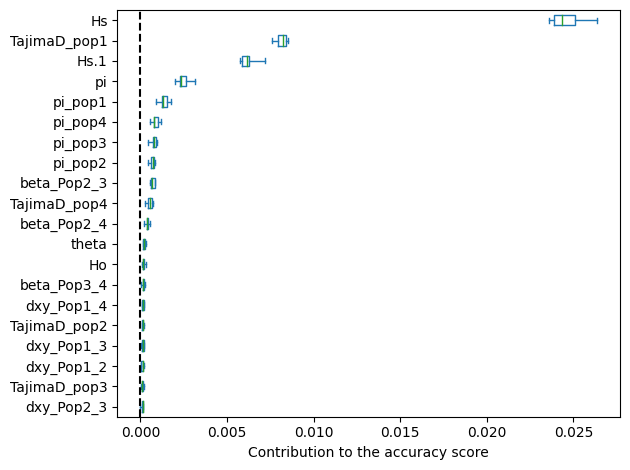

In [46]:
# Permutation Importance to retrieve the importance of each feature
result_forest = permutation_importance(forest, X_train, y_train, n_repeats=10,
                                 random_state=42)

sorted_importances_idx = result_forest.importances_mean.argsort()
importances = pd.DataFrame(
    result_forest.importances[sorted_importances_idx].T,
    columns=data.columns[sorted_importances_idx],
)

# Select the 20 most important features
top_importances = importances.iloc[:, -20:]

# Box plot of the 20 most relevant features
ax = top_importances.plot.box(vert=False, whis=10)
#ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Contribution to the accuracy score")
ax.figure.tight_layout()

In [47]:
#Create a pipeline for a histogram-based gradient boosting model
boost = make_pipeline(
    StandardScaler(), HistGradientBoostingClassifier(random_state=42)
)

#Evaluate the model with a ten-fold cross-validation
crossval(boost, X_train, y_train, outer_cv)

The average accuracy is 0.856 ± 0.004


{'fit_time': array([0.81930423, 0.76260328, 0.8765142 , 0.90100121, 0.76014662,
        0.75922322, 0.91039371, 0.74025583, 0.71793795, 0.74162269]),
 'score_time': array([0.01381421, 0.01323748, 0.01527166, 0.01577592, 0.01328135,
        0.01367211, 0.01627207, 0.01324368, 0.0128653 , 0.01343775]),
 'estimator': [Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('histgradientboostingclassifier',
                   HistGradientBoostingClassifier(random_state=42))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('histgradientboostingclassifier',
                   HistGradientBoostingClassifier(random_state=42))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('histgradientboostingclassifier',
                   HistGradientBoostingClassifier(random_state=42))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('histgradientboostingclassifier',
                   HistGradientBoost

In [48]:
#From the analysis above we want to analyse the following hyperparameters:
param_distributions_boost = {
    'histgradientboostingclassifier__max_depth': np.logspace(0, 2, num=20).astype(np.int32),
    'histgradientboostingclassifier__max_iter': np.logspace(1, 4, num=5).astype(np.int32)
}

boost_random_search = RandomizedSearchCV(
    boost,
    param_distributions=param_distributions_boost,
    cv=inner_cv,
    n_jobs=2,
    verbose=1,
    random_state=42
)

boost_random_search.fit(X_train, y_train)
boost_random_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'histgradientboostingclassifier__max_iter': 1778,
 'histgradientboostingclassifier__max_depth': 48}

In [49]:
#We want to further analyse the following hyperparameters:
best_depth_boost = boost_random_search.best_params_['histgradientboostingclassifier__max_depth']
best_n_boost = boost_random_search.best_params_['histgradientboostingclassifier__max_iter']
#best_depth_boost = 6
#best_n_boost = 10000

param_distributions_boost_bis = {
    'histgradientboostingclassifier__max_depth': np.linspace(best_depth_boost-5, best_depth_boost+5, num=10).astype(np.int32),
    'histgradientboostingclassifier__max_iter': np.linspace(best_n_boost-10, best_n_boost+10, num=5).astype(np.int32)
}

boost_random_search_bis = GridSearchCV(
    boost,
    param_grid=param_distributions_boost_bis,
    cv=inner_cv,
    n_jobs=2,
    verbose=1,
)

boost_random_search_bis.fit(X_train, y_train)
boost_random_search_bis.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'histgradientboostingclassifier__max_depth': 43,
 'histgradientboostingclassifier__max_iter': 1768}

The average accuracy is 0.856 ± 0.004
              precision    recall  f1-score   support

       hyp00       0.83      0.69      0.75      5000
       hyp01       0.97      1.00      0.98      5000
       hyp02       0.79      0.85      0.82      4723
       hyp03       0.82      0.88      0.85      5000

    accuracy                           0.85     19723
   macro avg       0.85      0.85      0.85     19723
weighted avg       0.85      0.85      0.85     19723



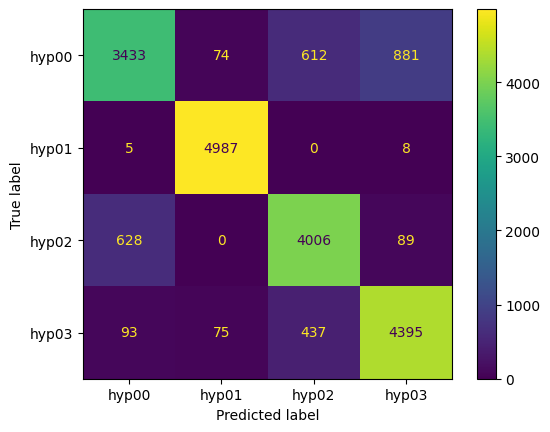

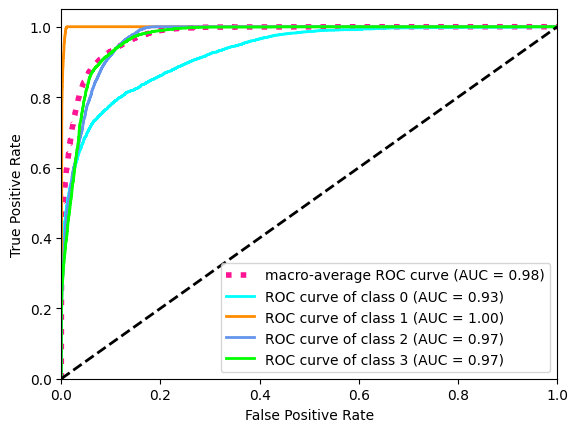

/home/pierrot/.local/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


array([[0.06254017, 0.72959419, 0.0027533 , 0.20511234]])

In [50]:
#We can now rerun the analysis with the best hyperparameters and plot a report of the model performance on the test set
best_depth_boost_bis = boost_random_search_bis.best_params_['histgradientboostingclassifier__max_depth']
best_n_boost_bis = boost_random_search_bis.best_params_['histgradientboostingclassifier__max_iter']
#best_depth_boost_bis = 7
#best_n_boost_bis = 9990

boost = make_pipeline(
    StandardScaler(), HistGradientBoostingClassifier(random_state = 42, 
                                             max_depth = best_depth_boost_bis,
                                             max_iter = best_n_boost_bis)
)
res_boost = crossval(boost, X_train, y_train, outer_cv)
y_boost = report(res_boost, X_test, y_test, target_names)
plot_multiclass_roc(X_train, y_train, X_test, y_test, boost)
boost.predict_proba(sample_life)

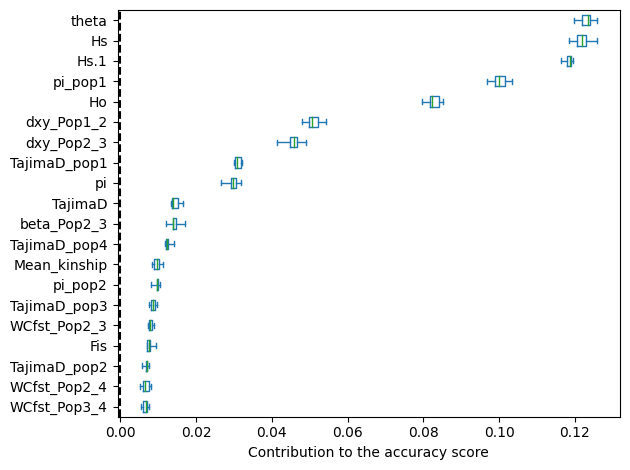

In [51]:
# Permutation Importance to retrieve the importance of each feature
result_boost = permutation_importance(boost, X_train, y_train, n_repeats=10,
                                 random_state=42)

sorted_importances_idx = result_boost.importances_mean.argsort()
importances = pd.DataFrame(
    result_boost.importances[sorted_importances_idx].T,
    columns=data.columns[sorted_importances_idx],
)

# Select the 20 most important features
top_importances = importances.iloc[:, -20:]

# Box plot of the 20 most relevant features
ax = top_importances.plot.box(vert=False, whis=10)
#ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Contribution to the accuracy score")
ax.figure.tight_layout()

The following three algorithms are left aside as suggested by my supervisor.

In [52]:
"""#Create a pipeline for a voting model
voting = make_pipeline(VotingClassifier(
        estimators = [('logistic regression', logistic), 
                    ('decision tree', tree), 
                    ('random forest', forest),
                    ('gradient boosting', boost)],
        voting = 'hard')
)

#Evaluate the model with a ten-fold cross-validation
crossval(voting, data, target, outer_cv)"""

"#Create a pipeline for a voting model\nvoting = make_pipeline(VotingClassifier(\n        estimators = [('logistic regression', logistic), \n                    ('decision tree', tree), \n                    ('random forest', forest),\n                    ('gradient boosting', boost)],\n        voting = 'hard')\n)\n\n#Evaluate the model with a ten-fold cross-validation\ncrossval(voting, data, target, outer_cv)"

In [53]:
"""#Create a pipeline for a stacking model
stacking = StackingClassifier(estimators = [('decision tree', tree), 
                                            ('random forest', forest),
                                            ('gradient boosting', boost)],
                            final_estimator = logistic)

#Evaluate the model with a ten-fold cross-validation
crossval(stacking, data, target, outer_cv)"""

"#Create a pipeline for a stacking model\nstacking = StackingClassifier(estimators = [('decision tree', tree), \n                                            ('random forest', forest),\n                                            ('gradient boosting', boost)],\n                            final_estimator = logistic)\n\n#Evaluate the model with a ten-fold cross-validation\ncrossval(stacking, data, target, outer_cv)"

In [54]:
"""#Create a pipeline for an AdaBoost model
ada = make_pipeline(
    StandardScaler(), AdaBoostClassifier(random_state=42)
)

#Evaluate the model with a ten-fold cross-validation
crossval(ada, data, target, outer_cv)"""

'#Create a pipeline for an AdaBoost model\nada = make_pipeline(\n    StandardScaler(), AdaBoostClassifier(random_state=42)\n)\n\n#Evaluate the model with a ten-fold cross-validation\ncrossval(ada, data, target, outer_cv)'